In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pygmt
import rf
import obspy
from math import ceil

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize



In [2]:
try:
    dataroot = os.environ["DATADIR"]
except KeyError:
    dataroot = "rf_data/processed/"
try:
    run = os.environ['RUN']
except KeyError:
    print("Using latest run")
    run = max(
        [
            os.path.join(dataroot, d)
            for d in os.listdir(dataroot)
            if os.path.isdir(os.path.join(dataroot, d))
        ],
        key=os.path.getmtime,
    )
stream = rf.read_rf(os.path.join(run, "rfstream.h5"), format='h5')
stacks = rf.read_rf(os.path.join(run, "rfstacks.h5"), format='h5').sort(["delay","network", "station"])

delays_df = pd.read_csv(os.path.join(run, "delays.txt"), names=("Network", "Station", "Longitude", "Latitude", "TPsb"), sep="\s+")
delays_df.set_index("Station", inplace=True)
delays_df.head()

Using latest run


,Network,Longitude,Latitude,TPsb
Station,,,,
WAA13,6C,119.4222,-32.2602,0.02
WAA14,6C,119.5182,-32.2761,0.02
WAA16,6C,119.5706,-32.0975,0.02
WAA05,6C,119.2362,-32.0373,0.04
WAA11,6C,119.3741,-32.3929,0.04


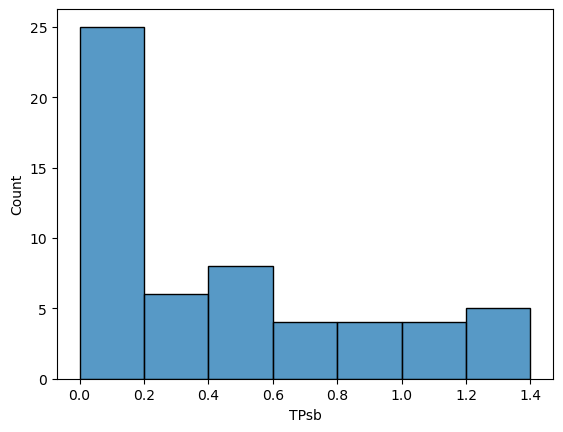

In [3]:
sns.histplot(data=delays_df, x="TPsb")

In [4]:
delays_df[delays_df["TPsb"] > 2]

,Network,Longitude,Latitude,TPsb
Station,,,,


In [5]:
delays_df[delays_df["TPsb"] < 0]

,Network,Longitude,Latitude,TPsb
Station,,,,


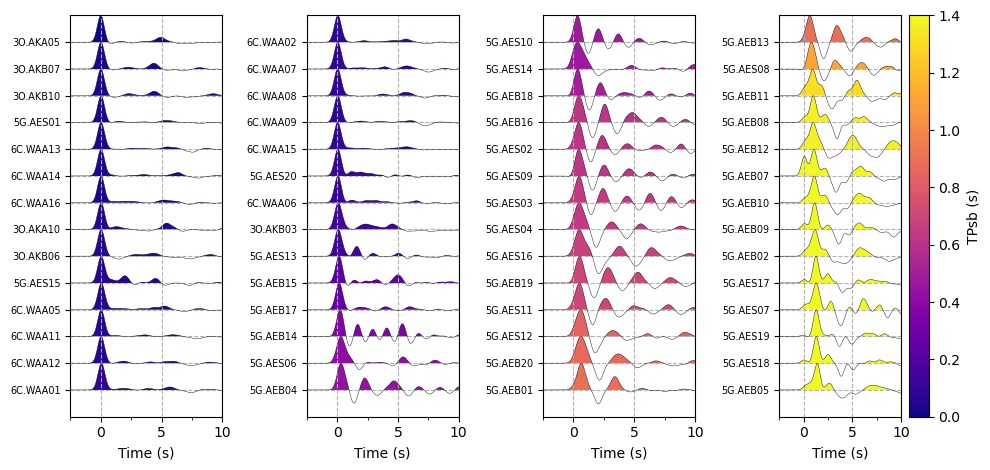

In [6]:
delays = [trace.stats.delay for trace in stacks]
norm = Normalize(vmin=min(delays), vmax=max(delays))
cmap = cm.plasma
nstacks = len(stacks)
ncols = 4
stacks_per_column = ceil(nstacks / ncols)

stack_height = 0.2
column_height = stack_height * stacks_per_column
fig, axs = plt.subplots(1, ncols, figsize=(10, column_height + 2), tight_layout=True)
for j, ax in enumerate(axs):
    i = 0
    column_stations = []
    while i < stacks_per_column:
        try:
            stack = stacks[j * stacks_per_column + i]
        except IndexError:
            # plot nothing so that what is plotted doesn't get stretched along y
            ax.plot(times, data + i, alpha=0)
            i += 1
            continue
        times = stack.times() - stack.stats.onset.second
        data = stack.data
        data /= data.max()
        level = stacks_per_column - 1 - i
        ax.fill_between(times, data + level, level, where=data>=0, fc=cmap(stack.stats.delay))
        ax.plot(times, data + level, "k", lw=0.3)
        column_stations.append(".".join([stack.meta.network, stack.meta.station]))
        i += 1
    while i:
        try:
            ax.set_yticks(np.arange(stacks_per_column - 1, stacks_per_column - 1 - i, -1))
            ax.set_yticklabels(column_stations, fontsize="x-small", horizontalalignment="right")
        except ValueError:  # i != len(column_stations) 
            i -= 1
        else:
            break

for ax in axs:
    ax.xaxis.set_minor_locator(MultipleLocator(2.5))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.set_xlim([-2.5, 10])
    ax.set_ylim([-1, stacks_per_column])
    ax.grid(True, ls="--")
    ax.set_xlabel("Time (s)")

sm = cm.ScalarMappable(norm, cmap=cmap)
plt.colorbar(sm, label="TPsb (s)", ax=axs[-1])
fig.savefig(os.path.join(run, "allstacks.pdf"))

In [7]:
events = {}
for tr in stream:
    m = tr.meta
    if m.event_id not in events:
        events[m.event_id.split("=")[-1]] = [m.event_longitude, m.event_latitude, m.event_depth, m.event_magnitude, m.distance]
events_df = pd.DataFrame(data=events, index=("Longitude", "Latitude", "Depth", "Magnitude", "Distance")).T
events_df.head()

,Longitude,Latitude,Depth,Magnitude,Distance
615738774,169.8763,-21.6982,21.8070,5.89,31.366351
616744097,169.8130,-21.6655,19.0678,5.44,41.192971
615945633,-176.3906,-21.8245,183.6643,5.66,44.859395
616173310,-177.9340,-31.1297,31.0423,5.72,39.094147
615958611,139.4712,38.6233,17.8002,6.44,65.754377


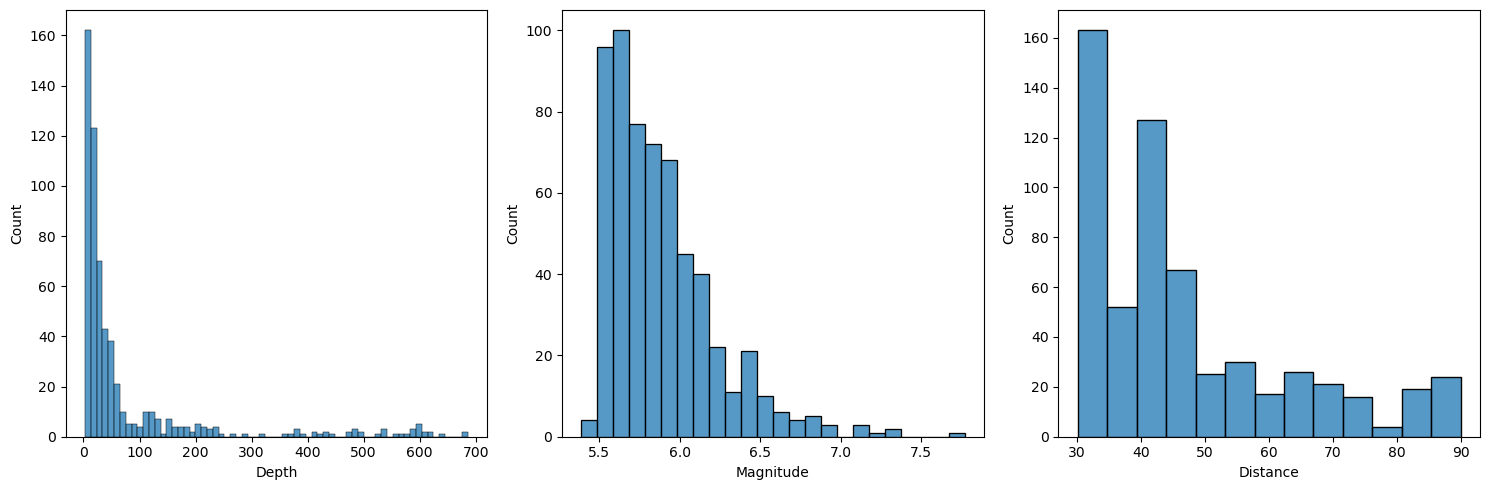

In [8]:
plot_these = ["Depth", "Magnitude", "Distance"]
fig, axs = plt.subplots(1, 3, figsize=(15,5), tight_layout=True)
for ax, d in zip(axs, plot_these):
    sns.histplot(data=events_df, x=d, ax=ax)
    ax.set_xlabel(d)

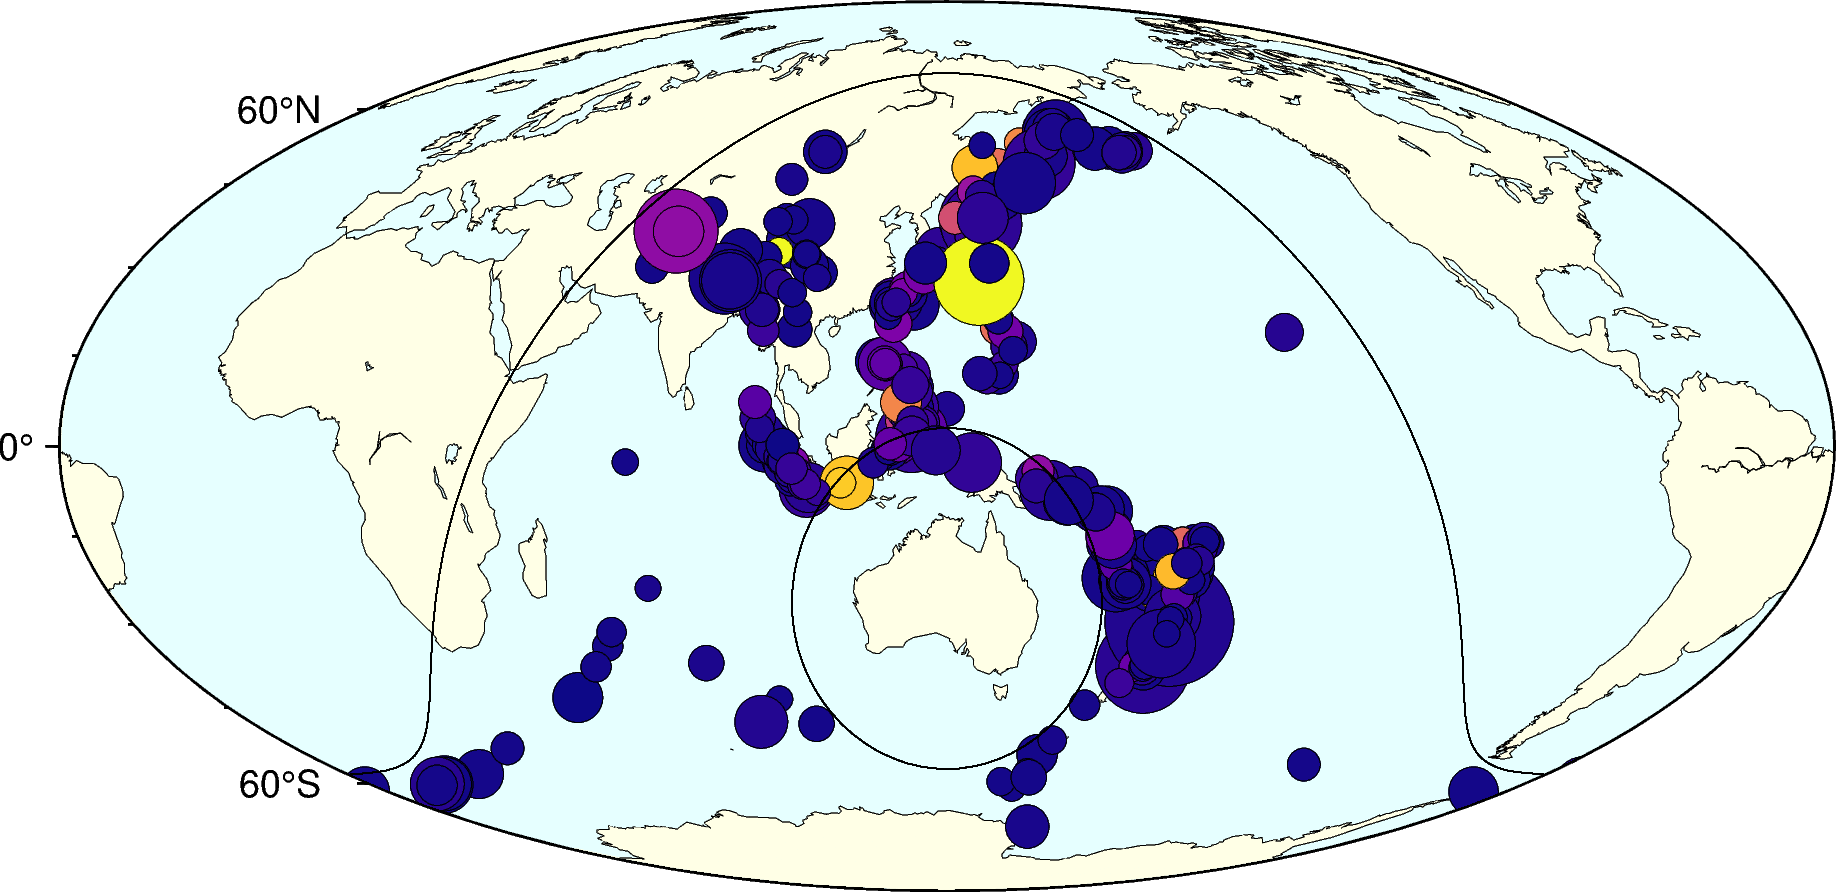

In [9]:
lon = (112 + 155) / 2
lat = (-46 + -8) / 2

region = "d"
projection = f"W{lon}/15c"
fig = pygmt.Figure()
fig.basemap(region=region, projection=projection)
fig.coast(
    region=region,
    projection=projection,
    area_thresh=10000,
    shorelines="0.1,black,solid",
    land="#ffffe6",
    water="#e6ffff",
)
pygmt.makecpt(cmap="plasma", series=[events_df.Depth.min(), events_df.Depth.max()])
fig.plot(
    region=region,
    projection=projection,
    x=events_df.Longitude,
    y=events_df.Latitude,
    size=0.005 * (2**events_df.Magnitude),
    style="cc",
    fill=events_df.Depth,
    cmap=True,
    pen="0.1p,black"
)
fig.plot(
    region=region,
    projection=projection,
    x=[lon] * 2,
    y=[lat] * 2,
    size=[30 *2, 95*2],
    style="E-d",
)

fig.show()
